<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/cnn_model_balanced_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection based on CICIDS 2017 Data Set (2)

We use the pre-processing dataset from mlp4nids (Multi-layer perceptron for network intrusion detection). https://github.com/ArnaudRosay/mlp4nids. Use another colab script to conver parquet files to csv files. 

In [1]:
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        print(df)

In [3]:
def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d

In [4]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

## Step 1. Loading csv files

Connect to Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# All columns
col_names = np.array(['Source Port', 'Destination Port',
                      'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min', 'Label'])

In [7]:
# load three csv files generated by mlp4nids (Multi-layer perceptron for network intrusion detection )
# first load the train set
df_train = pd.read_csv('/content/drive/My Drive/CICIDS2017/train_set.csv',names=col_names, skiprows=1)  

In [8]:
# Here we can see the number of rows and columns for each table.
print(df_train.shape)

(556548, 72)


Count the number of attacks

In [9]:
df_train['Label'].value_counts()

BENIGN                        278274
DoS Hulk                      115062
PortScan                       79402
DDoS                           64012
DoS GoldenEye                   5146
FTP-Patator                     3967
SSH-Patator                     2948
DoS slowloris                   2898
DoS Slowhttptest                2749
Bot                              978
Web Attack  Brute Force         753
Web Attack  XSS                 326
Infiltration                      18
Web Attack  Sql Injection        10
Heartbleed                         5
Name: Label, dtype: int64

Read test and validation sets

In [8]:
df_test = pd.read_csv('/content/drive/My Drive/CICIDS2017/test_set.csv',names=col_names, skiprows=1)  
print('Test set size: ', df_test.shape)

df_val = pd.read_csv('/content/drive/My Drive/CICIDS2017/crossval_set.csv',names=col_names, skiprows=1)  
print('Validation set size: ', df_val.shape)

Test set size:  (278270, 72)
Validation set size:  (278270, 72)


Distribution of different attack cases

In [10]:
print('Test set: ')
df_test['Label'].value_counts()

Test set: 


BENIGN                        139135
DoS Hulk                       57531
PortScan                       39701
DDoS                           32006
DoS GoldenEye                   2573
FTP-Patator                     1983
SSH-Patator                     1474
DoS slowloris                   1449
DoS Slowhttptest                1374
Bot                              489
Web Attack  Brute Force         376
Web Attack  XSS                 163
Infiltration                       9
Web Attack  Sql Injection         5
Heartbleed                         2
Name: Label, dtype: int64

In [12]:
print('Validation set: ')
df_val['Label'].value_counts()

Validation set: 


BENIGN                        139135
DoS Hulk                       57531
PortScan                       39701
DDoS                           32006
DoS GoldenEye                   2573
FTP-Patator                     1983
SSH-Patator                     1474
DoS slowloris                   1449
DoS Slowhttptest                1374
Bot                              489
Web Attack  Brute Force         376
Web Attack  XSS                 163
Infiltration                       9
Web Attack  Sql Injection         5
Heartbleed                         2
Name: Label, dtype: int64

## Step 2. Normalization

The continuous feature values are normalized into the same feature space. This is important when using features that have different measurements, and is a general requirement of many machine learning algorithms. Therefore, the values for this dataset are also normalized using the Min-Max scaling technique, bringing them all within a range of [0,1].

### Step 2.1 Encoding train dataset
Encoding the labels, and generate numpy array. Note that the label has not been encoded as one-hot coding. We will use one-hot code later. 

In [9]:
df_label = df_train['Label']
data = df_train.drop(columns=['Label'])
X_train = data.values
y_train = encode_label(df_label.values)

### Step 2.2 Normalizing train dataset

In [109]:
from sklearn.preprocessing import MinMaxScaler

In [110]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64199192e-01, 2.67500000e-01, 6.67991250e-02],
       [8.60215054e-04, 3.36651758e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 6.98552397e-03, 1.61354247e-02, ...,
        0.00000000e+00, 6.92500000e-01, 6.92500000e-01],
       [0.00000000e+00, 3.19819170e-03, 2.81067803e-03, ...,
        9.18180611e-05, 2.06666667e-01, 2.06666667e-01],
       [0.00000000e+00, 4.59155592e-02, 5.83030421e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### Step 2.3. Encoding test dataset

In [111]:
dft_label = df_test['Label']
datat = df_test.drop(columns=['Label'])
X_test = datat.values
y_test = encode_label(dft_label.values)

### Step 2.4. Normalizing test dataset

In [112]:
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)
X_test

array([[0.00000000e+00, 1.88574865e-02, 3.72734867e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.61501211e-02, 9.09200241e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.79176755e-02, 6.22970535e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.45278450e-02, 5.05111245e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.40889958e-03, 1.83091266e-02, ...,
        8.72072356e-05, 8.33333333e-02, 8.32840583e-02],
       [0.00000000e+00, 6.50330728e-03, 1.88504848e-02, ...,
        0.00000000e+00, 8.22500000e-01, 8.22500000e-01]])

### Step 2.5 Encoding validation dataset

In [113]:
dfv_label = df_val['Label']
datav = df_val.drop(columns=['Label'])
X_val = datav.values
y_val = encode_label(dfv_label.values)

### Step 2.6. Normalizing validation dataset

In [114]:
scaler = MinMaxScaler()
X_val = scaler.fit_transform(X_val)
X_val

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0234824 , 0.03596298, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00078058, 0.00059772, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00169125, 0.00177089, ..., 0.        , 0.        ,
        0.        ],
       [0.03922518, 0.01580671, 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Step 3 One-hot encoding for labels

y_train, y_test and y_val have to be one-hot-encoded. That means they must have dimension (number_of_samples, 15), where 15 denotes number of classes.

In [115]:
from tensorflow.keras.utils import to_categorical

In [116]:
y_train = to_categorical(y_train, 15)
y_test = to_categorical(y_test, 15)
y_val = to_categorical(y_val, 15)

## Step 4. Build the model

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [25]:
#hyper-params
batch_size = 1024 # increasing batch size with more gpu added
input_dim = X_train.shape[1]
num_class = 15                   # 15 intrusion classes, including benign traffic class
num_epochs = 30
learning_rates = 1e-3
regularizations = 1e-3
optim = tf.keras.optimizers.Adam(lr=learning_rates, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

print(input_dim)
print(num_class)

71
15


In [26]:
#X_train_r = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train_r = np.zeros((len(X_train), input_dim, 1))
X_train_r[:, :, 0] = X_train[:, :input_dim]
print(X_train_r.shape)

(556548, 71, 1)


In [27]:
X_test_r = np.zeros((len(X_test), input_dim, 1))
X_test_r[:, :, 0] = X_test[:, :input_dim]
print(X_test_r.shape)

(278270, 71, 1)


In [28]:
X_val_r = np.zeros((len(X_val), input_dim, 1))
X_val_r[:, :, 0] = X_val[:, :input_dim]
print(X_val_r.shape)

(278270, 71, 1)


In [29]:
model = Sequential()

# input layer
model.add(Conv1D(filters=64, kernel_size=3, padding='same', input_shape=(71,1)))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))


model.add(Conv1D(filters=128, kernel_size=3))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_class))
model.add(Activation('softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 71, 64)            256       
_________________________________________________________________
batch_normalization (BatchNo (None, 71, 64)            284       
_________________________________________________________________
activation (Activation)      (None, 71, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 69, 128)           24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 69, 128)           276       
_________________________________________________________________
activation_1 (Activation)    (None, 69, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8832)              0

In [30]:
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

## Step 5. Training the model

In [31]:
# fit network
model.fit(X_train_r, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val_r, y_val), verbose=1)

Epoch 1/30
544/544 [==============================] - 15s 16ms/step - loss: 0.3761 - accuracy: 0.8867 - val_loss: 0.1968 - val_accuracy: 0.9491
Epoch 2/30
544/544 [==============================] - 8s 15ms/step - loss: 0.0919 - accuracy: 0.9689 - val_loss: 0.1204 - val_accuracy: 0.9620
Epoch 3/30
544/544 [==============================] - 8s 15ms/step - loss: 0.0805 - accuracy: 0.9719 - val_loss: 0.0859 - val_accuracy: 0.9694
Epoch 4/30
544/544 [==============================] - 8s 15ms/step - loss: 0.0742 - accuracy: 0.9737 - val_loss: 0.0852 - val_accuracy: 0.9736
Epoch 5/30
544/544 [==============================] - 8s 15ms/step - loss: 0.0644 - accuracy: 0.9777 - val_loss: 0.0692 - val_accuracy: 0.9763
Epoch 6/30
544/544 [==============================] - 8s 15ms/step - loss: 0.0564 - accuracy: 0.9804 - val_loss: 0.0874 - val_accuracy: 0.9649
Epoch 7/30
544/544 [==============================] - 8s 15ms/step - loss: 0.0541 - accuracy: 0.9814 - val_loss: 0.0664 - val_accuracy: 0.976

In [33]:
# evaluate model
accuracy = model.evaluate(X_test_r, y_test, batch_size=batch_size, verbose=0)
print(accuracy)

[0.06611747294664383, 0.9843748807907104]


Save the model

In [ ]:
model.save('/content/drive/My Drive/CICIDS2017/cicids2017cnn.h5')

## Step 6. Calculate Precision, Recall, and F-sore

Classification accuracy is the total number of correct predictions divided by the total number of predictions made for a dataset. As a performance measure, accuracy is inappropriate for imbalanced classification problems. The main reason is that the overwhelming number of examples from the majority class (or classes) will overwhelm the number of examples in the minority class, meaning that even unskillful models can achieve accuracy scores of 90 percent, or 99 percent, depending on how severe the class imbalance happens to be.

An alternative to using classification accuracy is to use precision and recall metrics.

In [34]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [35]:
df_label = df_test['Label']
ytest = encode_label(df_label.values)

In [36]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_r, verbose=0)

# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_r, verbose=0)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [37]:
print(yhat_probs.shape)
print(ytest.shape)

(278270,)
(278270,)


**Accuracy**

In [38]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(ytest, yhat_classes)
print('Accuracy: %f' % accuracy)

Accuracy: 0.984375


**Precision**

Precision calculates the accuracy for the minority class. It is calculated as the ratio of correctly predicted positive examples divided by the total number of positive examples that were predicted.

In [39]:
# precision tp / (tp + fp)
precision = precision_score(ytest, yhat_classes, labels=[1,2], average='micro')
# labels is a list of all possible class labels
print('Precision: %f' % precision)

Precision: 0.997210


**Recall**

Recall is the ratio of true positives to the ground-truth positives in the sample. Unlike Precision, Recall also considers the number of positive (minority) cases that were not classified as such.

In [40]:
# recall: tp / (tp + fn)
recall = recall_score(ytest, yhat_classes, average='weighted')
print('Recall: %f' % recall)

Recall: 0.984375


**F-Score**

Precision is appropriate when we are more concerned with minimizing false positives, while Recall is appropriate when the number of false negatives is more critica

In [41]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest, yhat_classes, average='weighted')
print('F1 score: %f' % f1)

F1 score: 0.983610


In [42]:
# kappa
kappa = cohen_kappa_score(ytest, yhat_classes)
print('Cohens kappa: %f' % kappa)

# confusion matrix
matrix = confusion_matrix(ytest, yhat_classes)
print(matrix)

Cohens kappa: 0.976714
[[137918     69     12     26    901     39      4     36      0      0
      90      3     37      0      0]
 [   199    290      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   132      0  31873      1      0      0      0      0      0      0
       0      0      0      0      0]
 [    12      0      0   2537     22      1      1      0      0      0
       0      0      0      0      0]
 [  1573      0      1      6  55951      0      0      0      0      0
       0      0      0      0      0]
 [    53      0      0      1      0   1309      8      0      0      0
       0      0      3      0      0]
 [    44      0      0      0      0     13   1391      0      0      0
       0      0      1      0      0]
 [     4      0      0      0      0      0      2   1976      0      0
       0      0      1      0      0]
 [     0      0      0      0      0      0      0      0      2      0
       0      0      0   

## Step 7. Using CNN2D Model

Convert each example as a 9x8 gray image.

Each example has 71 features. Add one additional column to have 72 features such that we can have 9x8 gray images.

In [117]:
X_train_enlarge = np.append(X_train, np.zeros([len(X_train),1]),1)
X_val_enlarge = np.append(X_val, np.zeros([len(X_val),1]),1)
X_test_enlarge = np.append(X_test, np.zeros([len(X_test),1]),1)

In [118]:
img_row = 9
img_col = 8

X_train_gray = np.array([x.reshape(img_row, img_col,1) for x in X_train_enlarge])
train_gray = np.array([x.reshape(img_row, img_col) for x in X_train_enlarge])

In [119]:
X_test_gray = np.array([x.reshape(img_row, img_col,1) for x in X_test_enlarge])
test_gray = np.array([x.reshape(img_row, img_col) for x in X_test_enlarge])

In [120]:
X_val_gray = np.array([x.reshape(img_row, img_col,1) for x in X_val_enlarge])
val_gray =  np.array([x.reshape(img_row, img_col) for x in X_val_enlarge])

In [121]:
X_train_gray.shape

(556548, 9, 8, 1)

In [122]:
X_test_gray.shape

(278270, 9, 8, 1)

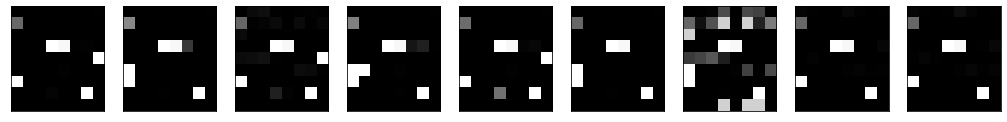

In [123]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(train_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

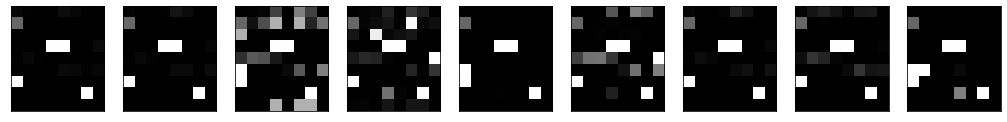

In [124]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

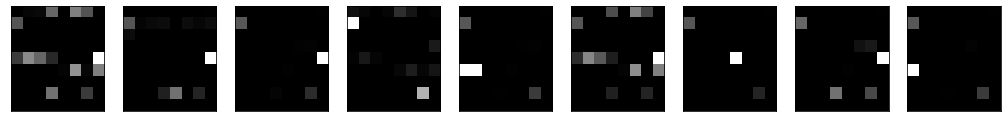

In [125]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(val_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [127]:
batch_size = 1000 # increasing batch size with more gpu added
 
num_class = 15                   # 15 intrusion classes, including benign traffic class
epochs = 40

In [128]:
model2d_g = Sequential()
model2d_g.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(9,8,1)))
model2d_g.add(Conv2D(64, kernel_size=(3,3), padding='same',  activation='relu'))
model2d_g.add(Flatten())
model2d_g.add(Dropout(0.2))
model2d_g.add(Dense(512))
model2d_g.add(Dense(num_class, activation='softmax'))
 
model2d_g.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 9, 8, 32)          320       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 9, 8, 64)          18496     
_________________________________________________________________
flatten_24 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 4608)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_49 (Dense)             (None, 15)                7695      
Total params: 2,386,319
Trainable params: 2,386,319
Non-trainable params: 0
___________________________________________

In [129]:
# training
model2d_g.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001), #,SGD(lr=0.01), #
              metrics=['accuracy'])

In [130]:
model2d_g.fit(X_train_gray, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_gray, y_val))

Epoch 1/40
557/557 [==============================] - 9s 15ms/step - loss: 0.5116 - accuracy: 0.8180 - val_loss: 0.4099 - val_accuracy: 0.8110
Epoch 2/40
557/557 [==============================] - 8s 15ms/step - loss: 0.1565 - accuracy: 0.9436 - val_loss: 0.7247 - val_accuracy: 0.7966
Epoch 3/40
557/557 [==============================] - 8s 15ms/step - loss: 0.1091 - accuracy: 0.9633 - val_loss: 0.7172 - val_accuracy: 0.7689
Epoch 4/40
557/557 [==============================] - 8s 15ms/step - loss: 0.0890 - accuracy: 0.9697 - val_loss: 0.6974 - val_accuracy: 0.7304
Epoch 5/40
557/557 [==============================] - 8s 14ms/step - loss: 0.0773 - accuracy: 0.9733 - val_loss: 0.8603 - val_accuracy: 0.7299
Epoch 6/40
557/557 [==============================] - 8s 14ms/step - loss: 0.0688 - accuracy: 0.9765 - val_loss: 0.5598 - val_accuracy: 0.7989
Epoch 7/40
557/557 [==============================] - 8s 14ms/step - loss: 0.0634 - accuracy: 0.9783 - val_loss: 0.6528 - val_accuracy: 0.7998

In [131]:
# evaluate model
accuracy = model2d_g.evaluate(X_test_gray, y_test, batch_size=batch_size, verbose=0)
print(accuracy)

[0.07864858955144882, 0.9820713400840759]


Convert each example as a 6x4 color image.

In [132]:
img_row = 6
img_col = 4

X_train_img = np.array([x.reshape(img_row, img_col, 3) for x in X_train_enlarge])
X_val_img = np.array([x.reshape(img_row, img_col, 3) for x in X_val_enlarge])
X_test_img = np.array([x.reshape(img_row, img_col, 3) for x in X_test_enlarge])

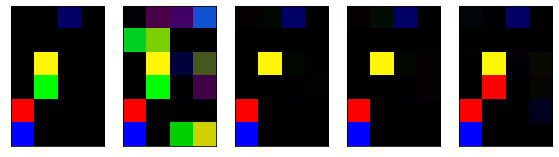

In [133]:
#ploting images for data
%matplotlib inline
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_train_img[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

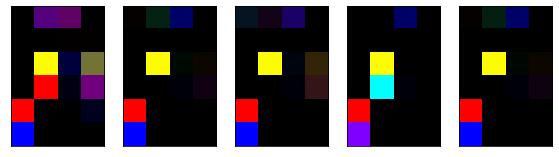

In [134]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_test_img[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [135]:
model2d = Sequential()
model2d.add(Conv2D(32, kernel_size=(1, 1), padding='same', activation='relu', input_shape=(6,4,3)))
model2d.add(Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu'))
model2d.add(Flatten()) 
model2d.add(Dropout(0.1))
model2d.add(Dense(512))
model2d.add(Dense(num_class, activation='softmax'))
 
model2d.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 6, 4, 32)          128       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 6, 4, 64)          2112      
_________________________________________________________________
flatten_25 (Flatten)         (None, 1536)              0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1536)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               786944    
_________________________________________________________________
dense_51 (Dense)             (None, 15)                7695      
Total params: 796,879
Trainable params: 796,879
Non-trainable params: 0
_______________________________________________

In [136]:
# training
model2d.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.01), #,SGD(lr=0.01), #
              metrics=['accuracy'])
model2d.fit(X_train_img, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_img, y_val))

Epoch 1/40
557/557 [==============================] - 4s 6ms/step - loss: 0.7221 - accuracy: 0.7703 - val_loss: 0.2294 - val_accuracy: 0.9005
Epoch 2/40
557/557 [==============================] - 3s 6ms/step - loss: 0.2083 - accuracy: 0.9291 - val_loss: 0.2261 - val_accuracy: 0.8936
Epoch 3/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1720 - accuracy: 0.9440 - val_loss: 0.1358 - val_accuracy: 0.9522
Epoch 4/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1463 - accuracy: 0.9507 - val_loss: 0.1972 - val_accuracy: 0.9365
Epoch 5/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1388 - accuracy: 0.9526 - val_loss: 0.1799 - val_accuracy: 0.9016
Epoch 6/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1359 - accuracy: 0.9545 - val_loss: 0.2031 - val_accuracy: 0.9002
Epoch 7/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1221 - accuracy: 0.9585 - val_loss: 0.3816 - val_accuracy: 0.8337
Epoch 

In [137]:
# evaluate model
accuracy = model2d.evaluate(X_test_img, y_test, batch_size=batch_size, verbose=0)
print(accuracy)

[0.14182227849960327, 0.9685341715812683]


## Step 8. Reorder features according to their importance. 

According to "Selection and Performance Analysis of CICIDS2017 Features Importance", the important features are: Destination Port, Fwd IAT Min, Init_Win_bytes_Forward, Init_Win_bytes_backward and FlowIATMin

In [105]:
col_important = np.array(['Source Port', 'Destination Port', 'Fwd IAT Min', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Flow IAT Min',
                      'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Protocol', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min', 'Label'])

Load the data again.

In [106]:
# load train data
df_train = pd.read_csv('/content/drive/My Drive/CICIDS2017/train_set.csv',names=col_important, skiprows=1) 
df_train.head()

,,,,,,,,,,,,,,Source Port,Destination Port,Fwd IAT Min,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow IAT Min,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Protocol,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
5141,172.16.0.1-192.168.10.50-50294-80-6,172.16.0.1,50294.0,192.168.10.50,80.0,6.0,5/7/2017 10:33,63101744.0,7.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.110932,10500000.0,1.190000e+07,32100000.0,998158.0,63100000.0,1.050000e+07,1.190000e+07,32100000.0,998158.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.110932,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,29200.0,-1.0,0.0,40.0,7006133.0,0.0,7006133.0,7006133.0,18700000.0,12200000.0,32100000.0,8015895.0,DoS Slowhttptest
40963,172.16.0.1-192.168.10.50-37796-1199-6,172.16.0.1,37796.0,192.168.10.50,1199.0,6.0,7/7/2017 2:52,62.0,1.0,1.0,2.0,6.0,2.0,2.0,2.000000,0.000000,6.0,6.0,6.0,0.0,1.290323e+05,32258.064520,62.0,0.000000e+00,62.0,62.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.0,16129.032260,16129.032260,2.0,6.0,3.333333,2.309401,5.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.000000,2.000000,6.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,6.0,1024.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PortScan
27718,172.217.6.200-192.168.10.12-443-42634-6,172.217.6.200,443.0,192.168.10.12,42634.0,6.0,03/07/2017 09:49:12,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,666666.666667,3.0,0.000000e+00,3.0,3.0,3.0,3.000000e+00,0.000000e+00,3.0,3.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,666666.666667,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,357.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
106492,192.168.10.8-23.208.79.206-52235-443-6,192.168.10.8,52235.0,23.208.79.206,443.0,6.0,4/7/2017 11:46,5007496.0,7.0,4.0,1679.0,152.0,1080.0,0.0,239.857143,415.237052,152.0,0.0,38.0,76.0,3.656518e+02,2.196707,500749.6,1.543257e+06,4892570.0,3.0,5007496.0,8.345827e+05,2.018795e+06,4955369.0,3.0,87090.0,29030.0,31709.63089,63179.0,515.0,0.0,0.0,0.0,0.0,152.0,92.0,1.397904,0.798802,0.0,1080.0,152.583333,327.660428,107361.356100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,166.454545,239.857143,38.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1679.0,4.0,152.0,8192.0,946.0,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
63559,192.168.10.14-52.84.30.203-59835-80-6,52.84.30.203,80.0,192.168.10.14,59835.0,6.0,6/7/2017 10:04,4.0,1.0,1.0,6.0,6.0,6.0,6.0,6.000000,0.000000,6.0,6.0,6.0,0.0,3.000000e+06,500000.000000,4.0,0.000000e+00,4.0,4.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,250000.000000,250000.000000,6.0,6.0,6.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.000000,6.000000,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,115.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [107]:
df_test = pd.read_csv('/content/drive/My Drive/CICIDS2017/test_set.csv',names=col_important, skiprows=1) 
print('Test set size: ', df_test.shape)

df_val = pd.read_csv('/content/drive/My Drive/CICIDS2017/crossval_set.csv',names=col_important, skiprows=1) 
print('Validation set size: ', df_val.shape)

Test set size:  (278270, 72)
Validation set size:  (278270, 72)


Repeat most of above steps:

In [108]:
df_label = df_train['Label']
data = df_train.drop(columns=['Label'])
X_train = data.values
y_train = encode_label(df_label.values)

Go back and restart from step 2.2

unfortrunately, the feature importance does not improve the accuracy.